In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from torchvision import models, datasets, transforms
import json
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
import matplotlib.pyplot as plt
import random


# Homework 13 - Implementing CLIP

The goal of this homework is to implement a simple version of CLIP for educational purposes.

You will be using the MNIST dataset, along with the descriptions of the numbers (look at the file `number_descriptions.json`).

Our image encoder will be a pretrained ResNet18.
Our text encoder will be a pretrained DistilBERT model.

Both encoders will be used to encode images and text into a joint embedding space.

Finally, we will compute the contrastive loss between the image and text embeddings.

Note:
- We will be only training the image encoder projection and text encoder projection.
  This will enable fast training but limited expressiveness. Hence, it will be difficult to 
  train the model to generalize properly. The goal of this homework is to understand the algorithm.

In [2]:
class MNISTWithDescriptions(Dataset):
    def __init__(self, dataset, descriptions_path):
        self.dataset = dataset
        self.tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
        self.descriptions = json.load(open(descriptions_path))

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        description = random.choice(self.descriptions[str(label)])
        data = self.tokenizer(
            description,
            padding="max_length",
            truncation=True,
            max_length=32,
            return_tensors="pt",
        )
        return image, data, description, label


In [3]:
def get_mnist_data_loader(
    train_samples: int = 20000,
    val_samples: int = 2000,
    test_samples: int = 100,
    descriptions_path: str = "number_descriptions.json",
):
    transform = transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Lambda(
                lambda x: x.repeat(3, 1, 1)
            ),  # Convert grayscale to RGB by repeating the channel
            transforms.Normalize(
                (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
            ),  # Normalize all three channels
        ]
    )

    mnist = datasets.MNIST("./data", train=True, download=True, transform=transform)
    # shuffle dataset
    # Create train, val, test splits
    indices = list(range(len(mnist)))
    random.shuffle(indices)
    mnist = torch.utils.data.Subset(mnist, indices)

    # Split into train, val, test
    train_end = train_samples
    val_end = train_end + val_samples
    test_end = val_end + test_samples

    train_indices = indices[:train_end]
    val_indices = indices[train_end:val_end]
    test_indices = indices[val_end:test_end]

    mnist_train = torch.utils.data.Subset(mnist.dataset, train_indices)
    mnist_val = torch.utils.data.Subset(mnist.dataset, val_indices)
    mnist_test = torch.utils.data.Subset(mnist.dataset, test_indices)

    # Create custom dataset
    train_dataset = MNISTWithDescriptions(mnist_train, descriptions_path)
    val_dataset = MNISTWithDescriptions(mnist_val, descriptions_path)
    test_dataset = MNISTWithDescriptions(mnist_test, descriptions_path)
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    return train_loader, val_loader, test_loader


train_loader, val_loader, test_loader = get_mnist_data_loader()

Number: 6
Description: This is number six, Number of tokens: 128
Tokens: [[101, 2023, 2003, 2193, 2416, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]


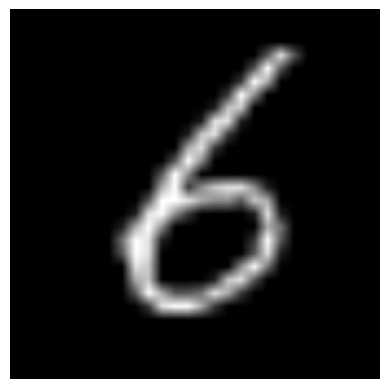

In [4]:
# Let's visualize some data
for image, data, description, label in train_loader:
    # Get first image from batch
    image = image[0, 0, :, :]
    description = description[0]
    label = label[0]
    print(
        f"Number: {label}\nDescription: {description}, Number of tokens: {data['input_ids'].shape[0]}"
    )
    print(f"Tokens: {data['input_ids'][0].tolist()}")
    plt.imshow(image, cmap="gray")
    plt.axis("off")
    plt.show()
    break

In [5]:
class SimpleCLIP(nn.Module):
    """
    A lightweight implementation of CLIP.

    For the image encoder, we use a pretrained ResNet18. Modify the final layer
    to output the embedding of the image (embed_dim-dimensional vector).

    For the text encoder, use `distilbert-base-uncased` model from Huggingface.
    We will use the [CLS] token representation from the transformer's output as the text embedding.

    Make sure to freeze all the parameters of the image encoder and text encoder.
    Only train the final linear layer of the image encoder and the text projection layer.
    (Otherwise the model will train for ever :))

    :param embed_dim: Dimension of the joint embedding space
    """

    def __init__(self, embed_dim=128):
        super(SimpleCLIP, self).__init__()

        # <your_code_here>
        # </your_code_here>

        # Temperature parameter for contrastive loss
        self.logit_scale = nn.Parameter(torch.ones([]) * 0.07)

    def encode_image(self, images):
        """
        Encode images into the joint embedding space.
        For that, use the pretrained ResNet18 with the modified final layer.
        It should output the embedding of the image (embed_dim-dimensional vector).
        Before returning, normalize the embeddings
        (normalize across the embedding dimension).

        :param images: Batch of images (B, C, H, W)
        :returns: Image embeddings (B, embed_dim)
            The embeddings should be normalized:
            - for training stability
            - for proper cosine similarity computation
        """
        # Forward pass through image encoder
        # <your_code_here>
        normalized_embeddings = None
        # </your_code_here>
        return normalized_embeddings

    def encode_text(self, tokens):
        """
        Encode text into the joint embedding space using a pretrained transformer.
        Run the text through the transformer and use the [CLS] token representation as the text embedding.
        The [CLS] token representations is the first element in the last hidden state of the transformer.
        Project the embeddings to the embed_dim-dimensional space.
        Before returning, normalize the embeddings.
        (normalize across the embedding dimension).
        For the forward pass through the text encoder use torch.no_grad() context manager (for speed and efficiency).
        :param tokens: Batch of tokenized text (output from tokenizer)
        :returns: Text embeddings (B, embed_dim)
        """
        # Forward pass through text encoder (use with torch.no_grad() context manager for speed)
        # <your_code_here>
        normalized_embeddings = None
        # </your_code_here>
        return normalized_embeddings

    def forward(self, images, tokens):
        """
        Forward pass for both image and text encoders.
        For that, use the `encode_image` and `encode_text` methods.

        :param images: Batch of images (B, C, H, W)
        :param tokens: Batch of tokenized text (output from tokenizer)
        :returns: Tuple of (image_embeddings, text_embeddings)
        """
        image_features = self.encode_image(images)
        text_features = self.encode_text(tokens)
        return image_features, text_features


def contrastive_loss(
    image_features: torch.Tensor, text_features: torch.Tensor, logit_scale: torch.Tensor
):
    """
    Compute the contrastive loss between image and text features.

    First, compute the similarity matrix between images and text.
    Then, compute the similarity matrix between text and images.
    Both matrices are complementary (one checks for similarity between
    images and text, the other checks for similarity between text and images).

    The shape of both matrices should be (B, B).
    The diagonal elements are positive pairs.
    Create the labels for the loss function appropriately.
    (diagonal elements are positive pairs, other elements are negative pairs).
    The labels should be of shape (B, B).

    :param image_features: Image embeddings (B, embed_dim)
    :param text_features: Text embeddings (B, embed_dim)
    :param logit_scale: Temperature parameter
    :returns: Contrastive loss value
    """
    # <your_code_here>
    logits_per_image = None
    logits_per_text = None
    labels = None
    # </your_code_here>
    # Compute cross-entropy losses
    loss_image = F.cross_entropy(logit_scale * logits_per_image, labels)
    loss_text = F.cross_entropy(logit_scale * logits_per_text, labels)

    # Average the losses
    return (loss_image + loss_text) / 2

In [6]:
def train(model, epochs, dataloaders, optimizer, device):
    """
    Train the model for one epoch.

    :param model: SimpleCLIP model
    :param dataloaders: Tuple of DataLoaders for training and validation data
    :param optimizer: Optimizer for training
    :param device: Device to train on
    :returns: Average loss for the epoch
    """
    model.to(device)
    model.train()

    train_loader, val_loader, _ = dataloaders

    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        train_loss = 0
        # Update this line to unpack all 4 values
        for batch_idx, (images, tokens, descriptions, labels) in tqdm(
            enumerate(train_loader), desc="Training", total=len(train_loader)
        ):
            images = images.to(device)
            tokens = {
                "input_ids": tokens["input_ids"]
                .squeeze(1)
                .to(device),  # Remove extra dimension
                "attention_mask": tokens["attention_mask"]
                .squeeze(1)
                .to(device),  # Remove extra dimension
            }

            # Forward pass
            image_features, text_features = model(images, tokens)

            # Compute loss
            loss = contrastive_loss(image_features, text_features, model.logit_scale)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        val_loss = 0
        for batch_idx, (images, tokens, descriptions, labels) in tqdm(
            enumerate(val_loader), desc="Validation", total=len(val_loader)
        ):
            images = images.to(device)
            tokens = {
                "input_ids": tokens["input_ids"].squeeze(1).to(device),
                "attention_mask": tokens["attention_mask"].squeeze(1).to(device),
            }
            image_features, text_features = model(images, tokens)
            loss = contrastive_loss(image_features, text_features, model.logit_scale)
            val_loss += loss.item()

        print(
            f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss / len(train_loader):.4f}, Val Loss: {val_loss / len(val_loader):.4f}"
        )
    # Save the model
    torch.save(model.state_dict(), "simple_clip.pth")
    return train_loss / len(train_loader), val_loss / len(val_loader)


model = SimpleCLIP()
train(
    model,
    epochs=10,
    dataloaders=get_mnist_data_loader(),
    optimizer=torch.optim.Adam(model.parameters(), lr=1e-4),
    device="mps",
)


/Users/damian/Code/laba/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/damian/Code/laba/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Validation: 100%|██████████| 16/16 [00:06<00:00,  2.35it/s]


Epoch 1/10, Train Loss: 4.8309, Val Loss: 4.8021
Epoch 2/10


Validation: 100%|██████████| 16/16 [00:07<00:00,  2.20it/s]


Epoch 2/10, Train Loss: 4.8019, Val Loss: 4.7858
Epoch 3/10


Validation: 100%|██████████| 16/16 [00:06<00:00,  2.52it/s]


Epoch 3/10, Train Loss: 4.7786, Val Loss: 4.7746
Epoch 4/10


Validation: 100%|██████████| 16/16 [00:06<00:00,  2.54it/s]


Epoch 4/10, Train Loss: 4.7570, Val Loss: 4.7634
Epoch 5/10


Validation: 100%|██████████| 16/16 [00:06<00:00,  2.46it/s]


Epoch 5/10, Train Loss: 4.7370, Val Loss: 4.7555
Epoch 6/10


Validation: 100%|██████████| 16/16 [00:06<00:00,  2.56it/s]


Epoch 6/10, Train Loss: 4.7178, Val Loss: 4.7440
Epoch 7/10


Validation: 100%|██████████| 16/16 [00:06<00:00,  2.53it/s]


Epoch 7/10, Train Loss: 4.6999, Val Loss: 4.7357
Epoch 8/10


Validation: 100%|██████████| 16/16 [00:07<00:00,  2.25it/s]


Epoch 8/10, Train Loss: 4.6822, Val Loss: 4.7281
Epoch 9/10


Validation: 100%|██████████| 16/16 [00:06<00:00,  2.34it/s]


Epoch 9/10, Train Loss: 4.6662, Val Loss: 4.7199
Epoch 10/10


Validation: 100%|██████████| 16/16 [00:06<00:00,  2.46it/s]


Epoch 10/10, Train Loss: 4.6503, Val Loss: 4.7136


(4.650322027267165, 4.713635861873627)

Take a look at the inference results below. 
Comment on the results.
What does precision and recall tell us? How do they compare to the total accuracy? May the accuracy be misleading? What does the potentially high precision and low recall tell us about our classifier?

/Users/damian/Code/laba/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/damian/Code/laba/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


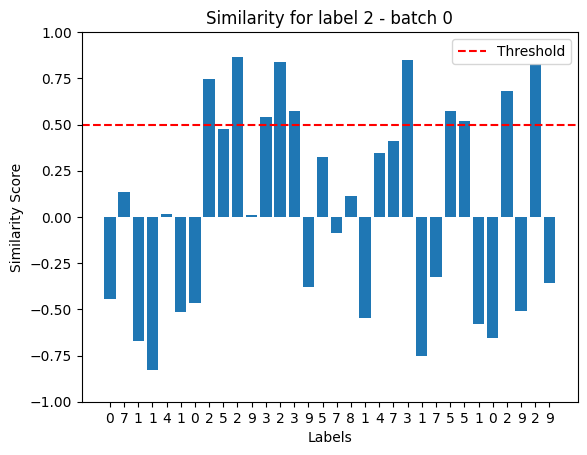

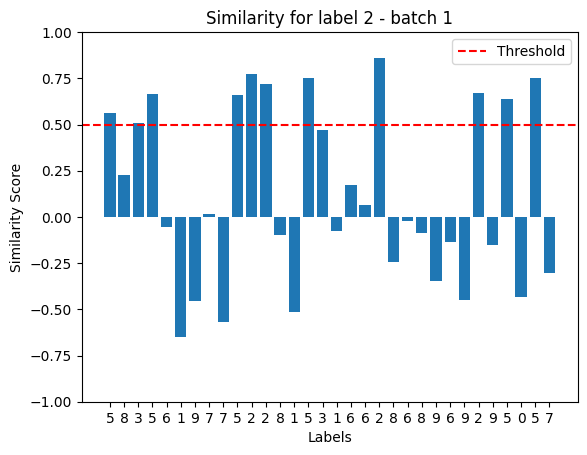

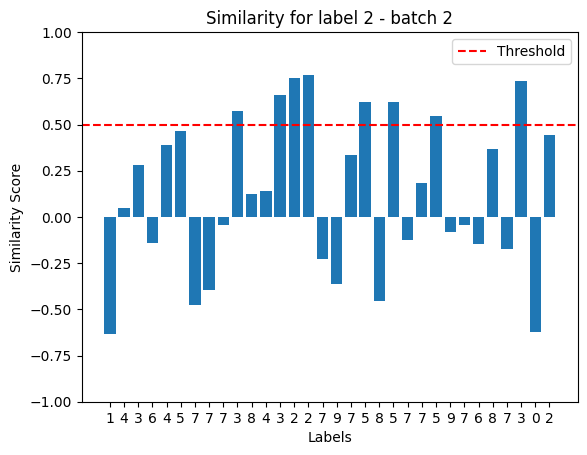

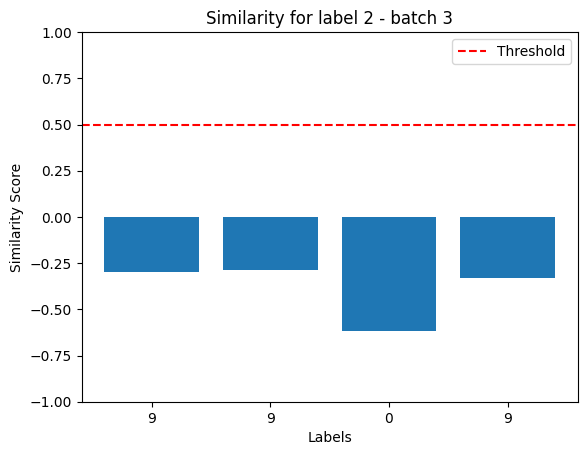

Total accuracy: 0.9167
Precision: 0.3793
Recall: 0.9167


In [7]:
# Run inference
model = SimpleCLIP()
device = "mps"
model.load_state_dict(torch.load("simple_clip.pth"))
model.to(device)
model.eval()

text = "This is number two"
target_label = 2
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
text_tokens = tokenizer(
    text, padding="max_length", truncation=True, max_length=32, return_tensors="pt"
)
# Preprocess the text tokens: remove the extra dimension and move to the device
text_tokens = {
    "input_ids": text_tokens["input_ids"].squeeze(1).to(device),
    "attention_mask": text_tokens["attention_mask"].squeeze(1).to(device),
}

# Initialize counters for true positives, predicted positives, and actual positives
total_true_positives = 0
total_predicted = 0
total_actual = 0

for idx, (image, _, _, labels) in enumerate(test_loader):
    labels = labels.to(device)
    image = image.to(device)

    # Forward pass: obtain image and text features
    image_features, text_features = model(image, text_tokens)

    # Compute cosine similarity between features
    similarity = F.cosine_similarity(image_features, text_features)
    threshold = 0.5
    predicted_positives = similarity > threshold

    # Identify true positives where the model predicted above threshold and the label matches the target label
    true_positives = predicted_positives & (labels == target_label)

    # Accumulate counts
    total_true_positives += true_positives.sum().item()
    total_predicted += predicted_positives.sum().item()
    total_actual += (labels == target_label).sum().item()

    # Plot bar chart with labels on x-axis and similarity scores on y-axis (scaled from -1 to 1)
    plt.figure()
    plt.title(f"Similarity for label {target_label} - batch {idx}")
    x_labels = [str(l.item()) for l in labels.cpu()]
    similarity_values = similarity.cpu().detach().numpy()
    plt.bar(range(len(x_labels)), similarity_values)
    plt.xticks(range(len(x_labels)), x_labels)
    plt.xlabel("Labels")
    plt.ylabel("Similarity Score")
    plt.ylim(-1, 1)
    plt.axhline(y=threshold, color="red", linestyle="--", label="Threshold")
    plt.legend()
    plt.show()

# Compute precision, recall, and accuracy safely (avoid division by zero)
precision = total_true_positives / total_predicted if total_predicted > 0 else 0
recall = total_true_positives / total_actual if total_actual > 0 else 0
accuracy = total_true_positives / total_actual if total_actual > 0 else 0

print(f"Total accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
